In [0]:
from google.colab import drive

In [6]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

### Loading the data

In [0]:
project_path = "/content/drive/My Drive/"

### Extract the zip file 
Extract Aligned Face Dataset from Pinterest.zip

In [0]:
zipfilename = "Aligned Face Dataset from Pinterest.zip"

In [0]:
from zipfile import ZipFile

with ZipFile(project_path+ zipfilename, 'r') as z:
  z.extractall()

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 

In [0]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [11]:
metadata.shape

(10770,)

Totally 10770 images are available

In [0]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [13]:
load_image(metadata[0].image_path())

array([[[125,  79,  17],
        [124,  78,  16],
        [126,  80,  21],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   2]],

       [[125,  79,  17],
        [125,  79,  19],
        [126,  80,  21],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   2]],

       [[126,  80,  20],
        [125,  79,  19],
        [126,  80,  21],
        ...,
        [  0,   0,   0],
        [  0,   0,   2],
        [  0,   0,   2]],

       ...,

       [[245, 218, 147],
        [245, 218, 147],
        [245, 219, 145],
        ...,
        [  0,   1,   0],
        [  0,   1,   2],
        [  0,   0,   2]],

       [[245, 218, 147],
        [245, 218, 147],
        [245, 219, 145],
        ...,
        [  0,   0,   2],
        [  0,   1,   2],
        [  0,   0,   2]],

       [[244, 217, 146],
        [244, 217, 146],
        [245, 219, 145],
        ...,
        [  0,   0,   0],
        [  0,   1,   0],
        [  0,   0,   0]]

### Display sample images from loaded data

In [0]:
from matplotlib import pyplot as plt

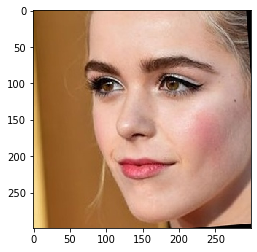

In [15]:
plt.imshow(load_image(metadata[0].image_path()))
plt.show()

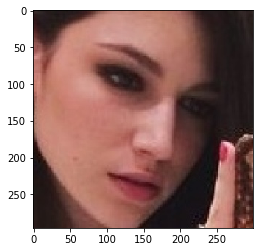

In [16]:
plt.imshow(load_image(metadata[389].image_path()))
plt.show()

In [17]:
load_image(metadata[0].image_path()).shape

(299, 299, 3)

the image has 299 * 299 shape with three channels. we need to resize this to 224 * 224 for using the vgg model

In [0]:
img_h = 224
img_w = 224

In [0]:
def resize_and_normalize():
  #images  are resized to 224 * 224 and the values normalized
  image_set =np.zeros((metadata.shape[0], img_h, img_w, 3))
  for i in range(metadata.shape[0]) :
    img = load_image(metadata[i].image_path())
    img = cv2.resize(img, dsize = (224,224))
    img = (img / 255.).astype(np.float32)
    image_set[i, :, :, :] = img
  return image_set

In [0]:
image_set = resize_and_normalize()

In [21]:
image_set.shape

(10770, 224, 224, 3)

Now all the images are resized so we can input directly to the VGG model and create embedings

*An embedding is a mapping of a discrete — categorical — variable to a vector of continuous numbers. In the context of neural networks, embeddings are low-dimensional, learned continuous vector representations of discrete variables. Neural network embeddings are useful because they can reduce the dimensionality of categorical variables and meaningfully represent categories in the transformed space.*

source: medium.com

# VGG Face model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

The vgg face model has many convolution layers , maxpooling layers and finally softmax activation giving an output of shape 2622 *1

In [24]:
model = vgg_face()
print(model.summary())


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________

In [0]:
#Loading pretrained weights
model.load_weights(project_path+'vgg_face_weights.h5')

In [0]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [27]:
image_set[0].shape

(224, 224, 3)

In [28]:
# creating a sample embedding_vector to analyze
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(image_set[0], axis=0))[0]
print(embedding_vector.shape)

(2622,)


In [29]:
embedding_vector.dtype

dtype('float32')

In [30]:
embedding_vector

array([ 0.00193466, -0.0251253 , -0.0090635 , ..., -0.017279  ,
        0.0112519 ,  0.00667891], dtype=float32)

# Generate embeddings for each image in the dataset

In [0]:
# creating an empty array to store embeddings
embeddings = np.empty([metadata.shape[0], 2623] ,dtype=object )

In [32]:
embeddings.shape

(10770, 2623)

In [0]:
import re
#import regular expression to extract

In [0]:
# the embeddings are created for all the images
for i in range(image_set.shape[0]) :
  embeddings[i,:2622] = vgg_face_descriptor.predict(np.expand_dims(image_set[i], axis=0))[0]
  embeddings[i,2622] = re.sub('pins_',"",metadata[i].name)

In [37]:
#view a sample embedding
embeddings[0]

array([0.001934656291268766, -0.025125298649072647, -0.009063499979674816,
       ..., 0.011251895688474178, 0.0066789123229682446,
       'kiernan shipka '], dtype=object)

# Function to calculate distance between given 2 pairs of images.¶
Consider distance metric as "Squared L2 distance"

Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [0]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

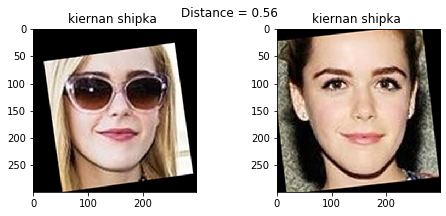

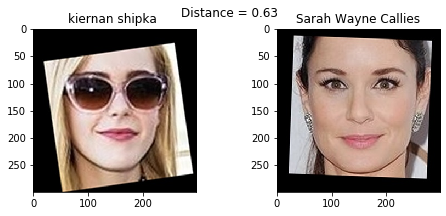

In [41]:
def show_pair(idx1, idx2):
    fig = plt.figure(figsize=(8,3))
    fig.suptitle(f'Distance = {distance(embeddings[idx1,:2622], embeddings[idx2,:2622]):.2f}')
    ax1 = plt.subplot(121)
    ax1.title.set_text(embeddings[idx1,2622])
    plt.imshow(load_image(metadata[idx1].image_path()))
    ax2 = plt.subplot(122)
    ax2.title.set_text(embeddings[idx2,2622])
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

we can see in the above sample that the distance between embeddings are greater than 0.5 even between the same person.

It may be because of the sun glasses. Let us see more example

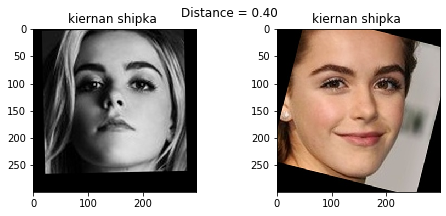

In [42]:
show_pair(30, 31)

here it is less than 0.5 as we guessed

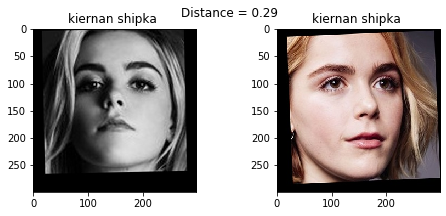

In [43]:
show_pair(30, 100)

Again less than 0.5 distance between the same person

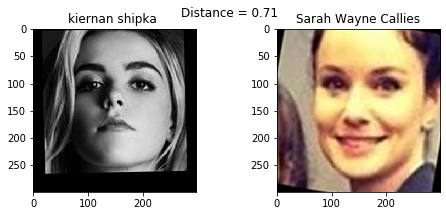

In [44]:
show_pair(30, 280)

Greater than 0.5 between different persons

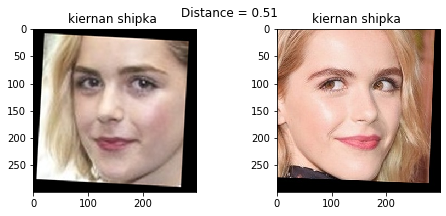

In [45]:
show_pair(70, 72)

on the margin of 0.5 between the same person

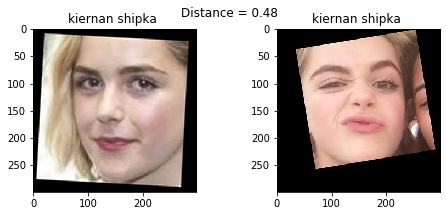

In [46]:
show_pair(70, 115)

Again on the margin of 0.5 between the same person


These distances clearly indicate how the embeddings are representing our images in the transformed space. The embeddings of the same person are closer compared to that of different person.

In [0]:
#let us create a pandas dataframe with the embeddings
import pandas as pd

embeddings_df = pd.DataFrame(data = embeddings)

In [48]:
embeddings_df.shape

(10770, 2623)

It has 10770 rows with 2622 columns representing the image and one column for name

In [49]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2583,2584,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622
0,0.00193466,-0.0251253,-0.0090635,0.000804255,0.00807447,0.00907835,0.00506912,0.0279399,0.000355781,0.0155035,0.00721819,0.00840223,0.00249648,-0.0116336,0.0110106,0.00271323,0.0123505,-0.0278018,0.0105311,0.00299146,0.00987886,0.0152386,0.00850246,-0.000253443,0.00631382,-0.00448117,-0.00503679,-0.00401556,0.0085064,0.0317716,0.0126635,-0.00426658,-0.00439731,0.00593447,0.00137226,0.0127126,-0.0250956,-0.0175349,0.0224514,-0.0177223,...,-0.0325604,0.0203198,-0.0221006,-0.00498549,0.00677649,-0.0100112,0.00761338,-0.004174,0.000207397,-0.0212906,-0.00684222,0.0254903,-0.0238502,0.00734445,-0.021349,0.0110072,-0.0197974,0.0156713,-0.0128366,0.00561995,0.0309319,-0.0113325,-0.00507964,0.0180785,0.0120396,0.00582717,0.00877277,-0.00529464,-0.00713979,0.00713004,-0.000771072,-0.0128171,0.0219141,0.00111975,-0.0148958,-0.0100498,-0.017279,0.0112519,0.00667891,kiernan shipka
1,0.00674104,-0.00347826,-0.00824523,0.0186841,0.0154728,0.0232411,0.0113254,0.0262609,0.0105313,0.00516877,0.0281273,0.0181304,0.00368536,-0.000211608,0.0138747,0.0107244,0.0303762,0.0100227,0.00352134,0.0215025,0.0132851,0.0246168,0.00818465,0.00334459,0.000962834,0.00329023,0.00446792,0.00578627,0.0204867,0.019677,0.0138343,0.0103503,0.00333852,0.00641164,0.000409011,0.0046852,0.0017978,-0.00411911,0.0210366,0.0132406,...,-0.0135279,0.00629903,-0.0190759,-0.00139248,0.00331631,0.00946689,0.00854268,-0.0101859,-0.0034321,-0.0197153,0.00843703,0.022259,-0.0138953,0.00819941,-0.0153612,-0.0187421,-0.0101111,0.00792472,-0.0141861,-0.0187033,0.00118509,-0.0164938,-0.00659572,0.0143225,0.00713887,0.0037849,-0.00643146,-0.00524502,-0.00459021,-0.0134008,-0.0107598,-0.0183164,0.00982666,0.00757068,-0.00447803,-0.0222914,-0.0119662,0.00805513,0.0178733,kiernan shipka
2,-0.005158,0.00434785,-0.00764508,0.00941517,0.00685943,0.0120417,0.00268736,0.0123676,0.0117647,0.00420907,0.0351604,0.00280396,0.0163845,0.00819797,0.0190402,-0.00191398,0.0135381,0.0105707,0.00440172,0.0482034,0.00967744,0.0070508,-0.000753522,0.0202099,-0.00215228,-0.00947163,0.00863578,-0.00383068,0.00892803,0.0190919,0.01469,0.0180094,-0.0244207,0.00221084,0.00144595,0.0251425,-0.0205997,-0.0328656,0.00930448,-0.0214761,...,-0.0369917,0.00309858,-0.0336827,-0.0103234,0.00736704,0.00068828,0.0167944,-0.0174561,3.88817e-05,-0.00989709,0.00388409,0.0166051,-0.0129331,0.00420663,-0.0149841,-0.0274911,-0.0125727,0.0156885,-0.0230055,-0.00945231,0.00497376,-0.0192393,-0.0136814,0.0155237,0.016209,0.00898855,0.0167545,-0.00981459,-0.0108467,-0.00381026,0.0174687,-0.0202914,0.0382271,0.00927162,-0.00570023,-0.00603194,-0.0139029,0.00854039,0.0070438,kiernan shipka
3,0.00331691,-0.0211194,-0.00157908,-0.00483008,0.0282951,0.010814,-0.0309078,0.00878272,0.0259593,-0.00217734,-0.0022284,0.00717562,-0.00164091,-0.0146407,0.0114991,0.0192602,-0.000769398,-0.0127057,0.00717998,-0.000199308,0.0290695,0.0176065,0.00706694,0.011029,-0.00188358,0.00781342,0.00108805,-0.00944521,0.00285148,0.0275668,0.00720946,-0.00594021,-0.00839352,0.00342837,0.0115532,0.0179944,-0.0209795,-0.027142,0.00405295,-0.020394,...,-0.0269969,0.0177608,-0.0368367,-0.0122963,0.0119499,-0.0172974,0.0196612,-0.0103511,-0.0141202,-0.00512067,-0.0159409,0.0194343,-0.0221552,0.0122374,-0.023576,-0.0101627,-0.025247,0.0105987,-0.0150666,0.018734,0.027871,-0.00305435,-0.015332,0.0216819,0.0139937,0.0188862,0.0212385,0.000429373,0.00569034,-0.00422848,-0.00194907,-0.0118843,0.00783985,0.0189996,-0.0272344,-0.0125345,-0.0123492,0.0159605,0.000345806,kiernan shipka
4,-0.00512406,-0.0162223,-0.00798615,0.0146973,0.0186223,0.00468373,-0.00498391,0.03904,0.0189239,0.0075911,0.0206411,0.00893023,0.00229587,-0.0239866,0.00640208,0.0123347,-0.00

# Encode the Labels
The last column has the name as text, let us transform them into integers using label encoding.
This will prepare our data to be used by our classifiers.

Label encoder gives a number to each person name

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
embeddings_df['encoded_target'] = encoder.fit_transform(embeddings_df.iloc[:,-1])

In [51]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2584,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,encoded_target
0,0.00193466,-0.0251253,-0.0090635,0.000804255,0.00807447,0.00907835,0.00506912,0.0279399,0.000355781,0.0155035,0.00721819,0.00840223,0.00249648,-0.0116336,0.0110106,0.00271323,0.0123505,-0.0278018,0.0105311,0.00299146,0.00987886,0.0152386,0.00850246,-0.000253443,0.00631382,-0.00448117,-0.00503679,-0.00401556,0.0085064,0.0317716,0.0126635,-0.00426658,-0.00439731,0.00593447,0.00137226,0.0127126,-0.0250956,-0.0175349,0.0224514,-0.0177223,...,0.0203198,-0.0221006,-0.00498549,0.00677649,-0.0100112,0.00761338,-0.004174,0.000207397,-0.0212906,-0.00684222,0.0254903,-0.0238502,0.00734445,-0.021349,0.0110072,-0.0197974,0.0156713,-0.0128366,0.00561995,0.0309319,-0.0113325,-0.00507964,0.0180785,0.0120396,0.00582717,0.00877277,-0.00529464,-0.00713979,0.00713004,-0.000771072,-0.0128171,0.0219141,0.00111975,-0.0148958,-0.0100498,-0.017279,0.0112519,0.00667891,kiernan shipka,83
1,0.00674104,-0.00347826,-0.00824523,0.0186841,0.0154728,0.0232411,0.0113254,0.0262609,0.0105313,0.00516877,0.0281273,0.0181304,0.00368536,-0.000211608,0.0138747,0.0107244,0.0303762,0.0100227,0.00352134,0.0215025,0.0132851,0.0246168,0.00818465,0.00334459,0.000962834,0.00329023,0.00446792,0.00578627,0.0204867,0.019677,0.0138343,0.0103503,0.00333852,0.00641164,0.000409011,0.0046852,0.0017978,-0.00411911,0.0210366,0.0132406,...,0.00629903,-0.0190759,-0.00139248,0.00331631,0.00946689,0.00854268,-0.0101859,-0.0034321,-0.0197153,0.00843703,0.022259,-0.0138953,0.00819941,-0.0153612,-0.0187421,-0.0101111,0.00792472,-0.0141861,-0.0187033,0.00118509,-0.0164938,-0.00659572,0.0143225,0.00713887,0.0037849,-0.00643146,-0.00524502,-0.00459021,-0.0134008,-0.0107598,-0.0183164,0.00982666,0.00757068,-0.00447803,-0.0222914,-0.0119662,0.00805513,0.0178733,kiernan shipka,83
2,-0.005158,0.00434785,-0.00764508,0.00941517,0.00685943,0.0120417,0.00268736,0.0123676,0.0117647,0.00420907,0.0351604,0.00280396,0.0163845,0.00819797,0.0190402,-0.00191398,0.0135381,0.0105707,0.00440172,0.0482034,0.00967744,0.0070508,-0.000753522,0.0202099,-0.00215228,-0.00947163,0.00863578,-0.00383068,0.00892803,0.0190919,0.01469,0.0180094,-0.0244207,0.00221084,0.00144595,0.0251425,-0.0205997,-0.0328656,0.00930448,-0.0214761,...,0.00309858,-0.0336827,-0.0103234,0.00736704,0.00068828,0.0167944,-0.0174561,3.88817e-05,-0.00989709,0.00388409,0.0166051,-0.0129331,0.00420663,-0.0149841,-0.0274911,-0.0125727,0.0156885,-0.0230055,-0.00945231,0.00497376,-0.0192393,-0.0136814,0.0155237,0.016209,0.00898855,0.0167545,-0.00981459,-0.0108467,-0.00381026,0.0174687,-0.0202914,0.0382271,0.00927162,-0.00570023,-0.00603194,-0.0139029,0.00854039,0.0070438,kiernan shipka,83
3,0.00331691,-0.0211194,-0.00157908,-0.00483008,0.0282951,0.010814,-0.0309078,0.00878272,0.0259593,-0.00217734,-0.0022284,0.00717562,-0.00164091,-0.0146407,0.0114991,0.0192602,-0.000769398,-0.0127057,0.00717998,-0.000199308,0.0290695,0.0176065,0.00706694,0.011029,-0.00188358,0.00781342,0.00108805,-0.00944521,0.00285148,0.0275668,0.00720946,-0.00594021,-0.00839352,0.00342837,0.0115532,0.0179944,-0.0209795,-0.027142,0.00405295,-0.020394,...,0.0177608,-0.0368367,-0.0122963,0.0119499,-0.0172974,0.0196612,-0.0103511,-0.0141202,-0.00512067,-0.0159409,0.0194343,-0.0221552,0.0122374,-0.023576,-0.0101627,-0.025247,0.0105987,-0.0150666,0.018734,0.027871,-0.00305435,-0.015332,0.0216819,0.0139937,0.0188862,0.0212385,0.000429373,0.00569034,-0.00422848,-0.00194907,-0.0118843,0.00783985,0.0189996,-0.0272344,-0.0125345,-0.0123492,0.0159605,0.000345806,kiernan shipka,83
4,-0.00512406,-0.0162223,-0.00798615,0.0146973,0.0186223,0.00468373,-0.00498391,0.03904,0.0189239,0.0075911,0.0206411,0.00893023,0.00229587,-0.0239866,0.00640208,0.0123347,-0.00149917,0.00309985,0.00

Now we have added the column "encoded_target" which contains the target value as number



In [52]:
#checking an example
encoder.inverse_transform([83])[0]

'kiernan shipka '

As an example 'kiernan shipka' is coded as 83

# Create train and test sets

In [0]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

In [0]:
X_train = embeddings_df[train_idx].iloc[:, :-2]
X_test = embeddings_df[test_idx].iloc[:, :-2]
y_train = embeddings_df[train_idx].iloc[:, -1]
y_test = embeddings_df[test_idx].iloc[:, -1]


# Create SVM model with standard scaler and PCA dimensionality reduction and hyper parameter tuning with the help of GridSearchCV

In [0]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
n_folds = 5
scaling_options = [StandardScaler()]
no_of_PCA_features = [250, 320, 375, 450, 1024, 2048]
pipe = Pipeline([
 ('scaler', StandardScaler()),
 ('pca_reduction', PCA() ),
 ('model_gs' , svm.SVC())
])
param_grid_models = [
 {'scaler': scaling_options,
 'pca_reduction': [PCA()],
 'pca_reduction__n_components': no_of_PCA_features,
 'model_gs' : [svm.SVC()],
 'model_gs__C': [0.01, 0.05],
 'model_gs__gamma': [0.001, 0.01],
 'model_gs__kernel': ['poly', 'rbf'],
 'model_gs__degree': [1,2],
 'model_gs__decision_function_shape': ['ovo'],
 'model_gs__random_state': [42]}
]
#choosing njobs as -1 to have parallel processing
grid = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True , n_jobs=-1)

In [56]:
# Train the model
classifier = grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 134.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 292.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 330.6min finished


In [57]:
classifier.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca_reduction',
                 PCA(copy=True, iterated_power='auto', n_components=1024,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model_gs',
                 SVC(C=0.05, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovo', degree=1, gamma=0.01,
                     kernel='poly', max_iter=-1, probability=False,
                     random_state=42, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [0]:
best_estimator = classifier.best_estimator_


In [62]:
best_estimator[0]

StandardScaler(copy=True, with_mean=True, with_std=True)

In [63]:
best_estimator[1]

PCA(copy=True, iterated_power='auto', n_components=1024, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

# Test results

In [0]:
X_test_transformed = best_estimator[0].transform(X_test)
X_test_transformed = best_estimator[1].transform(X_test_transformed)

In [68]:
X_test_transformed[0]

array([ 7.45633152e+00,  6.28285865e+00, -1.18124242e+01, ...,
       -1.37217559e-01,  8.11804722e-03,  1.57718437e-01])

In [69]:
X_test_transformed.shape

(1197, 1024)

In [73]:
best_estimator[2]

SVC(C=0.05, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=1, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
predictions = best_estimator[2].predict(X_test_transformed)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [77]:
classification_report(y_true=y_test,y_pred=predictions)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        10\n           1       0.92      1.00      0.96        11\n           2       1.00      1.00      1.00        13\n           3       1.00      1.00      1.00        13\n           4       1.00      1.00      1.00         8\n           5       0.90      1.00      0.95         9\n           6       1.00      1.00      1.00         7\n           7       1.00      1.00      1.00        15\n           8       1.00      1.00      1.00        14\n           9       1.00      1.00      1.00         9\n          10       0.93      0.93      0.93        14\n          11       1.00      1.00      1.00        12\n          12       0.90      1.00      0.95         9\n          13       1.00      1.00      1.00         9\n          14       1.00      1.00      1.00        15\n          15       0.93      0.93      0.93        15\n          16       0.87      1.00      0.93        13\n       

accuracy                           0.96     

macro avg       0.96      0.96      0.96      

weighted avg       0.96      0.96      0.96     

we cannot pretty print the classification report here.
But as shown in the summary above, the accuracy comes to 96%
and the precision is also 96 percent.

In [78]:
confusion_matrix(y_true=y_test,y_pred=predictions)

array([[10,  0,  0, ...,  0,  0,  0],
       [ 0, 11,  0, ...,  0,  0,  0],
       [ 0,  0, 13, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 11,  0,  0],
       [ 0,  0,  0, ...,  0, 13,  0],
       [ 0,  0,  0, ...,  0,  0, 12]])

In [91]:
y_test.shape

(1197,)

In [0]:
import numpy.random as rn
random_test_idx = rn.choice(1197,size=(10,),replace=False)

In [93]:
random_test_idx

array([ 811,  428,   23,  627,  303,  852,   63, 1189,  686, 1069])

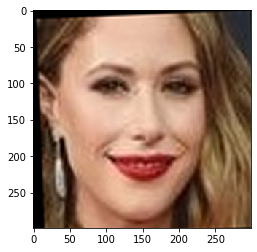

predicted name: Amanda Crew
name given in the data folder: PINS/pins_Amanda Crew/Amanda Crew4.jpg


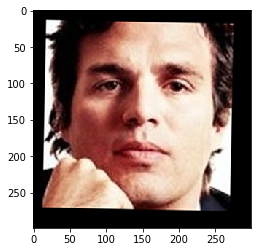

predicted name: Mark Ruffalo
name given in the data folder: PINS/pins_Mark Ruffalo/Mark Ruffalo52.jpg


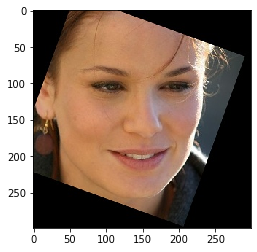

predicted name: millie bobby brown
name given in the data folder: PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies13.jpg


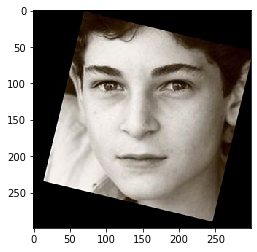

predicted name: david mazouz
name given in the data folder: PINS/pins_david mazouz/david mazouz89.jpg


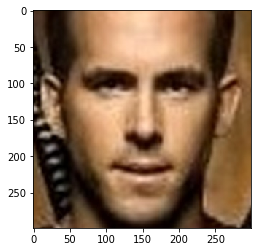

predicted name: Ryan Reynolds
name given in the data folder: PINS/pins_Ryan Reynolds/Ryan Reynolds3.jpg


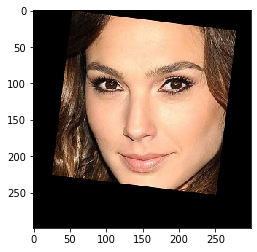

predicted name: gal gadot face
name given in the data folder: PINS/pins_gal gadot face/gal gadot face82.jpg


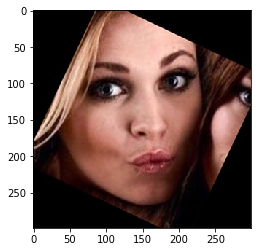

predicted name: eliza taylor
name given in the data folder: PINS/pins_eliza taylor/eliza taylor62.jpg


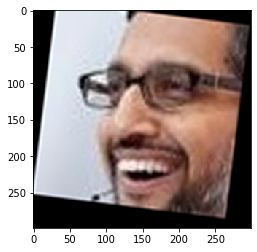

predicted name: Sundar Pichai
name given in the data folder: PINS/pins_Sundar Pichai/Sundar Pichai124_673.jpg


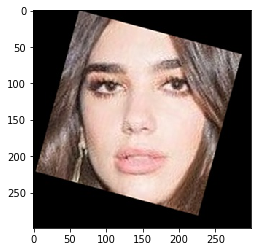

predicted name: dua lipa face
name given in the data folder: PINS/pins_dua lipa face/dua lipa face51.jpg


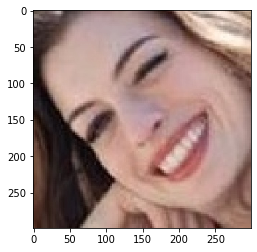

predicted name: margot robbie face
name given in the data folder: PINS/pins_anne hathaway/anne hathaway92.jpg


In [101]:
#let us randomly test few images
for i in random_test_idx:
  metadata_idx = i*9
  img_path = metadata[metadata_idx].image_path()
  plt.imshow(load_image(img_path))
  plt.show()
  pred = predictions[i]
  pred_name = encoder.inverse_transform([pred])[0]
  print("predicted name: "+pred_name)
  print("name given in the data folder: "+ img_path)
  

we can clearly see that for all the images we tested , the persons were identified exactly

# Conclusion


*   we have generated embeddings with the VGG face model using transfer learning
*   The embeddings were then given to traditional ML model SVM
* we have also optimized SVM with standard scaler, PCA and hypertuning
* The resulting model has an accuracy, precision and recall value of 96 percent

